In [102]:
import numpy as np
from numpy.random import rand, seed

## **1. Monte Carlo Methods**

We first consider Monte Carlo methods as a way to learn the state-value function for a given policy. Recall that the value of a state is the cumulative discounted future rewards starting from that state. An obvious way to estimate that function is from experience by averaging the returns observed after visits to that state. As the agent observes more realizations of the returns, the average should converge to the expected value.

The Monte Carlo methods learn value functions and optimal policies from experience in the form of sample episodes, as we devised in the previous module for the $k$-armed bandit problem. Even relative to dynamic programming methods, where we have complete knowledge of the environment, Monte Carlo methods that work with sample episodes alone can be a significant advantage. The main advantages of Monte Carlo methods are (i) the lack of an explicit model of transition probabilities and (ii) the outright focus on a small subset of the states that are relevant for the actions of the agents, without accurately evaluating the "uncharted" regions of the state set.

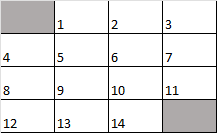

In [103]:
N = 16
GRID_WIDTH = np.sqrt(N)
NROWS = int(N / GRID_WIDTH)
S_GRID = np.linspace(1, N - 2, N - 2)
A = 4

# Build an array that indicates, for each state, the destination cells
# from moving up, down, right, or left
destinations = np.zeros((N, A), dtype=np.int8)
destinations[N - 1, :] = (N - 1) * np.ones((A), dtype=np.int8)
for ss in range(1, N - 1):
    # determine row of position ss in the grid
    row_ss = np.floor(ss / GRID_WIDTH) + 1

    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (
        ss - GRID_WIDTH < 0
    )
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (
        ss + GRID_WIDTH > N - 1
    )
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (
        ss >= row_ss * GRID_WIDTH - 1
    )
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (
        ss <= (row_ss - 1) * GRID_WIDTH
    )

print(destinations)

[[ 0  0  0  0]
 [ 1  5  2  0]
 [ 2  6  3  1]
 [ 3  7  3  2]
 [ 0  8  5  4]
 [ 1  9  6  4]
 [ 2 10  7  5]
 [ 3 11  7  6]
 [ 4 12  9  8]
 [ 5 13 10  8]
 [ 6 14 11  9]
 [ 7 15 11 10]
 [ 8 12 13 12]
 [ 9 13 14 12]
 [10 14 15 13]
 [15 15 15 15]]


Now we are going to slightly complicate the tasks of the agent in this model. Random gusts of wind are hitting the gridworld in a downward direction. These windy conditions are strongest in the "upper" part of the gridworld. That is, for each row of the gridworld, the agent will be moved downward from their current cell, regardless of the action taken by the agent. The probability will be higher in the uppermost part of the grid. We capture this assumption by defining the next array: 

In [104]:
# Set probability of down movement at each row

PDOWN = np.zeros((N))

PDOWN[0] = 0.8
PDOWN[1] = 0.4
PDOWN[2] = 0.2
PDOWN[3] = 0.1

With this setup, we are going to exploit the following function to determine the state in the following time step given some action and the effect of windy conditions:

In [105]:
def transition(state_init, action, dest, prdown, gridw, randnum):
    row_ss = np.floor(state_init / gridw)
    if randnum < prdown[int(row_ss)]:
        state_end = dest[int(state_init), 1]
    else:
        state_end = dest[int(state_init), action]
    return state_end

Monte Carlo methods rely on obtaining a record of histories across different "episodes" that, after averaging, allows for inferring the optimal value and policy functions of the agent. The agent will incrementally learn those functions as they gain experience and act according to that experience.

In the absence of a known model of the environment, it is particularly useful to estimate the values of state-action pairs, $Q(s,a)$ rather than state values $v(s)$. Thus, we are going to focus on $Q(s,a)$ as our main objective to optimize/estimate. Analogous with the policy iteration scheme we studied in Module 2, Monte Carlo methods first involve the computation of optimal state-action values for a given policy. We compute those values from repeated observations of the environment and then simply average the returns observed after visits to each state. As more returns are observed, the average should converge to the expected value. The second step consists of improving the policy given the state-action pairs involved. Repeating the two steps of the algorithm, we will reach the optimal objects.

Within an episode, each occurrence of state $s$ after taking action $a$ is called a visit to $(s,a)$. The pair $(s,a)$ may be visited multiple times in the same episode. "Every-visit" MC methods estimate the value of a state-action pair as the average of the rewards that have followed all the visits to it. "First-visit" MC methods average the rewards only following the first time in each episode that the state-action pair was visited and the action was selected. We can take both methods as essentially the same, though subject to some technicalities that we are going to ignore. 

Let's initialize the objects to optimize, policy and state-action function, and two arrays that at each episode will store the rewards obtained at each $(s,a)$ and the number of visits per $(s,a)$.

In [106]:
# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

# Initialize arrays of average rewards and number of visits per (s,a)
returns = np.zeros((N, A))
visits = np.zeros((N, A))

Many state-action pairs may never be visited by repeated experience. In the extreme case, a deterministic policy may not take some actions that are actually optimal, so we may have no experience to update the rewards from them. That is, we again face the exploration-exploitation trade-off. To overcome this issue, we can opt for "exploring starts" and also $\varepsilon$-greedy policies, as we studied in the previous module. 

The block of code below implements the "exploring starts" and $\varepsilon$-greedy policies that we are going to repeatedly exploit in the applications below:

In [107]:
def exploring_starts(nstates, randnum):
    for ss in range(nstates):
        if randnum < (ss + 1) / nstates:
            break
    return ss


def e_greedy_policy(nactions, pol, eps, randnum1, randnum2, randnum3):
    if randnum1 < eps:
        for aa in range(nactions):
            if randnum2 < (aa + 1) / A:
                break
    else:
        for aa in range(nactions):
            if randnum3 < np.cumsum(pol)[aa]:
                break
    return aa

For Monte Carlo policy evaluation, it is natural to alternate between evaluation and improvement on an episode-by-episode basis. Once we reach the end of an episode, the observed returns are used for policy evaluation, and then the policy is improved at all the states visited in the episode.

Below, we solve the model, using 5,000 episodes, each of which end after reaching either of the terminal states or after 100 movements. For exploration, we opt for "exploring starts," choosing at random the initial state, and a $\varepsilon$-greedy action choice. The iteration algorithm can be described in the following pseudo-code:

0. Initialize arrays of policies, $\Pi$, and state-action values, $Q$.
1. Loop over each episode. Choose random initial state, $s_0$:

  * Follow $\varepsilon$-greedy policy to determine action $a$, given $s_0$. Store visit to $(s_t,a_t)=(s_0,a)$, reward $r_t=r(s_0,a)$, and transition to next state $s_1$. Set $s_0 = s_1$ and iterate until the end of episode. 

  * Compute $G_t = r_t + \gamma G_{t+1}$. $G(s,a)$ records the value of the first visit, "first-visit" MC, or the average across all visits, "every-visit" MC, to the state-action pair.

  * Update average reward and state-action values: $Q(s,a) = Average[G(s,a)]$ across all previous episodes, for state-action pairs that have been visited in the episode.

  * Update the policy $\Pi(s)=\arg\underset{a}{\max}Q(s,a)$ and continue to next episode.

In one array, "history," we keep track of which state-action pairs are visited at each time step of the episode. In another array, `gfunc`, we store the value obtained at each time step of the episode. Recall that we assume that $\gamma=1$ in the gridworld model.

In [108]:
seed(1234)

# Monte Carlo method in windy gridworld
EPISODES = 5000
EPISODE_TMAX = 100
EPSILON = 0.5

# 1. Loop over episodes
for episode in range(EPISODES):
    qvalue_old = qvalue.copy()
    gfunc = np.zeros((EPISODE_TMAX))
    history = np.zeros((EPISODE_TMAX, 2), dtype=np.int8)
    # 1.1. Choose initial state
    ss0 = exploring_starts(N, rand())
    # Loop over each time step in the episode
    for tt in range(EPISODE_TMAX):
        # 1.2. Find optimal action given the current policy
        aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
        history[tt, :] = [int(ss0), aa]  # store state-action pair (s,a)
        # Determine which is the next state, given the action
        # and the probability of a downwards gust of wind
        tt_end = tt
        if ss0 < 1 or ss0 > N - 2:
            break
        ss0 = transition(ss0, aa, destinations, PDOWN, GRID_WIDTH, rand())
    # 1.3. Determine which is the value obtained at each time step on a backwards basis
    for tt in range(EPISODE_TMAX - 2, -1, -1):
        if history[tt, 0] > 0 and history[tt, 0] < N - 1:
            gfunc[tt] = -1 + gfunc[tt + 1]
    # Store first-visit value information
    state_mc = np.zeros((N, A))  # Stores if we have visited state-action pair (s,a)
    for tt in range(tt_end + 1):
        if (
            state_mc[history[tt, 0], history[tt, 1]] != 1
        ):  # Comment to make every-visit MC
            state_mc[history[tt, 0], history[tt, 1]] = 1
            returns[history[tt, 0], history[tt, 1]] += gfunc[tt]
            visits[history[tt, 0], history[tt, 1]] += 1
    # 1.4. Update the Q-function where the previous episode has gone through
    qvalue_new = np.divide(
        returns, visits, out=np.zeros_like(returns), where=visits != 0
    )
    qvalue = qvalue_new * (visits != 0) + qvalue_old * (visits == 0)
    # 1.5. Improve policy
    policy0 = np.argmax(qvalue, axis=1)
    policy = np.zeros((N, A))
    for ss in range(N):
        policy[ss, policy0[ss]] = 1.0

# Visits to each state-action
print(visits)
# State-action values
print(qvalue)
# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * int(GRID_WIDTH) : rr * int(GRID_WIDTH) + int(GRID_WIDTH)])

[[ 471.  104.   89.  102.]
 [  48.  113.   51.  181.]
 [  45.   67.  219.  103.]
 [ 279.   82.   68.   78.]
 [ 548.  136.  121.  117.]
 [ 123.  136.  527.  136.]
 [ 164.  184.  797.  166.]
 [ 216. 1012.  195.  202.]
 [ 537.  168.  156.  146.]
 [ 161.  188.  809.  168.]
 [ 264.  426. 1176.  273.]
 [ 334. 1892.  353.  355.]
 [ 191.  153.  677.  168.]
 [ 280.  260. 1187.  259.]
 [ 381.  331. 1807.  340.]
 [2653.  520.  529.  532.]]
[[ 0.          0.          0.          0.        ]
 [-8.10416667 -7.12389381 -7.43137255 -6.3038674 ]
 [-6.51111111 -6.04477612 -6.11872146 -6.78640777]
 [-4.84587814 -5.08536585 -5.01470588 -5.44871795]
 [-3.87408759 -8.29411765 -7.51239669 -7.13675214]
 [-7.90243902 -7.26470588 -6.18785579 -7.05882353]
 [-6.31097561 -5.28804348 -4.65244668 -6.39759036]
 [-4.51388889 -2.87450593 -4.08205128 -5.4009901 ]
 [-6.58472998 -8.57738095 -8.03846154 -9.        ]
 [-7.85714286 -6.10638298 -5.11124845 -8.19642857]
 [-5.78030303 -3.58215962 -3.11309524 -6.21611722]
 [-3.9

## **1. Temporal Difference Learning**

Temporal-Difference (TD) learning is a combination of Monte Carlo and dynamic programming (DP) notions of optimization. As in Monte Carlo methods, TD methods learn directly from experience without a model of the environment. As in DP, Temporal-Difference methods update estimates from states already updated, without waiting for a final outcome of an episode. This resembles the asynchronous dynamic programming technique that we described in Module 5 of this course. Some applications have very long episodes, so delaying all learning until the end of the episode slows down optimization. We consider two applications of Temporal Difference: SARSA and Q-Learning.

### **1.1 SARSA**

TD methods need to wait only until the next time step to update the increments to the optimization objects. At time $t$, they immediately make a useful update using the observed reward $r_t$ and the estimate of $Q$. The SARSA method starts by considering transitions from state-action pair to state-action pairs. That is, the estimation starts by a current observation of the state-action $(s_t,a_t)$, which yield a reward $r(s_t,a_t)$ and transition to state-action $(s_{t+1},a_{t+1})$. Importantly, the actions $a_t$ and $a_{t+1}$ arise from the optimal actions given states $s_t$ and $s_{t+1}$, respectively, using the current guess of policy, $\Pi$. Because of this, we refer to this algorithm as "on-policy" algorithm.

Given a vector of observations $(s_t,a_t,r_t,s_{t+1},a_{t+1})$, which gives the name to the optimization method, we can update the state-action value as:
$$
\begin{align*}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha\big[r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t) \big]
\end{align*} 
$$
where the parameter $\alpha$ captures the speed of adjustment of our guesses to the arrival of new information, as in the bandit problems we studied in the previous module.

A pseudo-code for the SARSA algorithm is as follows:

0. Initialize arrays of policies, $\Pi$, and state-action values, $Q$.
1. Loop over each episode. Choose random initial state, $s_0$, and corresponding optimal action $a_0$, from $\varepsilon$-greedy policy. 

  * At each time step $t$, observe reward $r(s_t,a_t)$ and transition to following state $s_{t+1}$. 
  * Choose $a_{t+1}$ following $\varepsilon$-greedy policy. 
  * Update $Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha\big[r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t) \big]$ and the policy $\Pi(s)=\arg\underset{a}{\max}Q(s,a)$.

  To implement SARSA in the windy gridworld, we initialize the state-action value and policies. We also set the number of episodes, their maximum duration, the $\varepsilon$-greedy probability, and the updating parameter $\alpha$.

In [109]:
# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

EPISODES = 5000
EPISODE_TMAX = 100
EPSILON = 0.5
ALPHA = 0.1

# SARSA method in windy gridworld

seed(1234)

for episode in range(EPISODES):
    # Choose initial state s
    ss0 = exploring_starts(N, rand())
    # e-greedy policy to choose a
    aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
    # Use policy to generate history
    for tt in range(EPISODE_TMAX):
        qvalue_old = qvalue.copy()
        if ss0 < 1 or ss0 > N - 2:
            break
        # Determine s' given (s,a)
        ss1 = transition(ss0, aa, destinations, PDOWN, GRID_WIDTH, rand())
        # e-greedy policy to choose a' given s'
        aa_prime = e_greedy_policy(
            A, policy[int(ss0), :], EPSILON, rand(), rand(), rand()
        )
        if ss1 > 0 and ss1 < N - 1:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (
                -1 + qvalue_old[ss1, aa_prime] - qvalue_old[ss0, aa]
            )
        else:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (-1 - qvalue_old[ss0, aa])
        # (s',a') --> (s,a) in next time step
        ss0 = ss1
        aa = aa_prime
        # Improve policy
        policy0[ss0] = np.argmax(qvalue[ss0, :])
        policy[ss0, :] = np.zeros((A))
        policy[ss0, int(policy0[ss0])] = 1.0
        ss0 = ss1


# State-action values
print(qvalue)
# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * int(GRID_WIDTH) : rr * int(GRID_WIDTH) + int(GRID_WIDTH)])

[[ 0.          0.          0.          0.        ]
 [-9.93168987 -9.58509896 -9.63826598 -7.97137369]
 [-7.20647752 -7.23989451 -6.96005411 -7.09230676]
 [-5.29694356 -4.647408   -5.28398029 -6.11463453]
 [-3.94437016 -9.98082478 -9.61748737 -8.86015727]
 [-8.75553621 -7.60106842 -7.34394637 -8.77896475]
 [-7.4590152  -5.45061531 -5.38657854 -7.13777675]
 [-5.08797493 -3.28816396 -4.38910376 -5.25688318]
 [-9.69296408 -8.53788561 -7.63463864 -8.93776612]
 [-8.39525458 -6.06294852 -5.4748638  -8.9580664 ]
 [-6.42055818 -4.13420314 -3.91725696 -7.03916287]
 [-4.52588759 -1.         -2.66106649 -5.16197067]
 [-9.13436033 -7.93195481 -5.89959777 -7.83253942]
 [-7.59400613 -5.92642614 -3.64881933 -7.74488823]
 [-5.52680219 -3.99304538 -1.01981697 -6.21201752]
 [ 0.          0.          0.          0.        ]]
[0. 3. 2. 1.]
[0. 2. 2. 1.]
[2. 2. 2. 1.]
[2. 2. 2. 0.]


### **1.2 Q-learning**

Contrary to the "on-policy" SARSA algorithm introduced above, Q-learning is an "off-policy" method that is defined by the following updating criterion:
$$
\begin{align*}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha\big[r_t + \gamma \underset{a}{\max}Q(s_{t+1},a) - Q(s_t,a_t) \big]
\end{align*} 
$$
That is, instead of choosing the action $a_{t+1}$ from the current policy (on-policy), we directly choose the action that maximizes the state-action value for the agent in step $t+1$ given the observed transition to state $s_{t+1}$ (off-policy). Notice that the current policy still determines which actions are followed and updated. This means that in step $t+1$ we observe $a_{t+1}$ as prescribed by the policy in state $s_{t+1}$, and not $\arg\underset{a}{\max}Q(s_{t+1},a)$.

A pseudo-code for the Q-learning algorithm is as follows:

0. Initialize arrays of policies, $\Pi$, and state-action values, $Q$.
1. Loop over each episode. Choose random initial state, $s_0$. 

  * At each time step $t$, choose optimal action $a_t$, from $\varepsilon$-greedy policy, observe reward $r(s_t,a_t)$ and transition to following state $s_{t+1}$. 
  * Update $Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha\big[r_t + \gamma \underset{a}{\max}Q(s_{t+1},a) - Q(s_t,a_t) \big]$ and the policy $\Pi(s)=\arg\underset{a}{\max}Q(s,a)$.

We initialize the optimization objects and the parameters of the estimation as above.

In [110]:
# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

EPISODES = 5000
EPISODE_TMAX = 100
EPSILON = 0.5
ALPHA = 0.1

# Q-Learning method in windy gridworld

seed(1234)

for episode in range(EPISODES):
    # Choose initial state
    ss0 = exploring_starts(N, rand())
    # Use policy to generate history
    for tt in range(EPISODE_TMAX):
        qvalue_old = qvalue.copy()
        if ss0 < 1 or ss0 > N - 2:
            break
        # e-greedy policy to choose a
        aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
        # Determine s' given (s,a)
        ss1 = transition(ss0, aa, destinations, PDOWN, GRID_WIDTH, rand())
        if ss1 > 0 and ss1 < N - 1:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (
                -1 + np.max(qvalue_old[ss1, :]) - qvalue_old[ss0, aa]
            )
        else:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (-1 - qvalue_old[ss0, aa])
        # Improve policy
        policy0[ss0] = np.argmax(qvalue[ss0, :])
        policy[ss0, :] = np.zeros((A))
        policy[ss0, int(policy0[ss0])] = 1.0
        ss0 = ss1

# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * int(GRID_WIDTH) : rr * int(GRID_WIDTH) + int(GRID_WIDTH)])

[0. 3. 2. 1.]
[0. 2. 2. 1.]
[2. 2. 2. 1.]
[2. 2. 2. 0.]


## **1. The Cliff Walk**

Consider the gridworld shown below. As in our gridworld in previous examples, this is an undiscounted episodic task, with start and goal states, and the actions causing movements up, down, right, or left. Rewards are -1 on all transitions except those into the region marked "THE CLIFF." If the agent steps into this region, it generates a reward of -100 and the agent returns to the start.

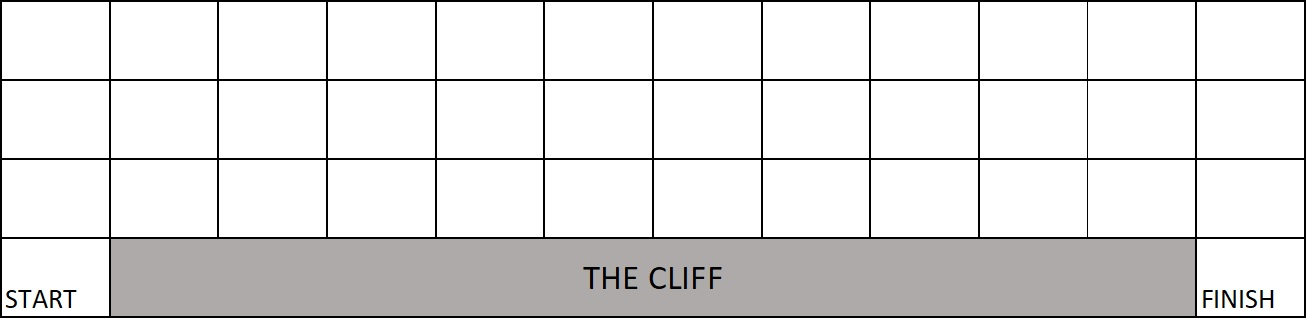

As before, we determine the transition paths across cells depending on each direction (action) taken. The code is general enough to allow for different grid sizes.

In [111]:
# The cliff walk: Comparing SARSA and Q-learning


GRID_WIDTH = 4
NROWS = 4
N = NROWS * GRID_WIDTH
A = 4

# Build an array that indicates, for each state, the destination cells
# from moving up, down, right, or left
destinations = np.zeros((N, A), dtype=np.int8)
for ss in range(0, (NROWS - 1) * GRID_WIDTH + 1):
    # determine row of position ss in the grid
    row_ss = np.floor(ss / GRID_WIDTH) + 1
    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (
        ss - GRID_WIDTH < 0
    )
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (
        ss + GRID_WIDTH > N - 1
    )
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (
        ss >= row_ss * GRID_WIDTH - 1
    )
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (
        ss <= (row_ss - 1) * GRID_WIDTH
    )
# Destinations from falling in the cliff
destinations[(NROWS - 1) * GRID_WIDTH + 1 : NROWS * GRID_WIDTH - 1, :] = (
    NROWS - 1
) * GRID_WIDTH

print(destinations)

[[ 0  4  1  0]
 [ 1  5  2  0]
 [ 2  6  3  1]
 [ 3  7  3  2]
 [ 0  8  5  4]
 [ 1  9  6  4]
 [ 2 10  7  5]
 [ 3 11  7  6]
 [ 4 12  9  8]
 [ 5 13 10  8]
 [ 6 14 11  9]
 [ 7 15 11 10]
 [ 8 12 13 12]
 [12 12 12 12]
 [12 12 12 12]
 [ 0  0  0  0]]


The next blocks of codes implement the SARSA and Q-Learning algorithms to determine the optimal actions of the agent in the cliff walk. Note that we are applying exploring starts to the algorithm, even though the "rules" determine that the agent should always start in the same cell. This fosters exploration but has no relevant impact on the final outcome. You can check it yourself!

In [112]:
# SARSA method in cliff walk

seed(1234)

# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

EPISODES = 2000
EPISODE_TMAX = 500
EPSILON = 0.5
ALPHA = 0.1

for episode in range(EPISODES):
    # Choose initial state
    ss0 = exploring_starts(N, rand())
    # e-greedy policy to choose a
    aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
    # Use policy to generate history
    for tt in range(EPISODE_TMAX):
        qvalue_old = qvalue.copy()
        if ss0 > N - 2:
            break
        # Determine s' given (s,a)
        ss1 = destinations[int(ss0), aa]
        # e-greedy policy to choose a'
        aa_prime = e_greedy_policy(
            A, policy[int(ss1), :], EPSILON, rand(), rand(), rand()
        )
        if ss1 < N - 1:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (
                -1 * (ss1 <= (NROWS - 1) * GRID_WIDTH)
                - 100 * (ss1 > (NROWS - 1) * GRID_WIDTH)
                + qvalue_old[ss1, aa_prime]
                - qvalue_old[ss0, aa]
            )
        else:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (-1 - qvalue_old[ss0, aa])
        aa = aa_prime
        # Improve policy
        policy0[ss0] = np.argmax(qvalue[ss0, :])
        policy[ss0, :] = np.zeros((A))
        policy[ss0, int(policy0[ss0])] = 1.0
        ss0 = ss1

# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * GRID_WIDTH : rr * GRID_WIDTH + GRID_WIDTH])

[2. 2. 2. 1.]
[0. 0. 2. 1.]
[0. 0. 2. 1.]
[0. 2. 0. 0.]


Notice how the optimal policies from SARSA opt for a "safe" path that avoids the row of cells just above the cliff. That is, choices of "up" (action 0) dominate in that part of the grid, while "right" dominates elsewhere and "down" is prevalent once the agent has reached the right edge of the grid. We can just ignore the decisions made at the cliff since any action will be irrelevant.

In [113]:
# Q-Learning method in cliff walk

seed(1234)

# Assume an initial policy that is random
policy = np.ones((N, A)) / A
qvalue = np.zeros((N, A))

# Array to fill with optimal action at each cell
policy0 = np.zeros((N))

EPISODES = 2000
EPISODE_TMAX = 500
EPSILON = 0.1
ALPHA = 0.1

for episode in range(EPISODES):
    # Choose initial state
    ss0 = exploring_starts(N, rand())
    # Use policy to generate history
    for tt in range(EPISODE_TMAX):
        qvalue_old = qvalue.copy()
        if ss0 > N - 2:
            break
        # e-greedy policy to choose a
        aa = e_greedy_policy(A, policy[int(ss0), :], EPSILON, rand(), rand(), rand())
        # Determine S' given (S,A)
        ss1 = destinations[int(ss0), aa]
        if ss1 < N - 1:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (
                -1 * (ss1 <= (NROWS - 1) * GRID_WIDTH)
                - 100 * (ss1 > (NROWS - 1) * GRID_WIDTH)
                + np.max(qvalue_old[ss1, :])
                - qvalue_old[ss0, aa]
            )
        else:
            qvalue[ss0, aa] = qvalue_old[ss0, aa] + ALPHA * (-1 - qvalue_old[ss0, aa])
        # Improve policy
        policy0[ss0] = np.argmax(qvalue[ss0, :])
        policy[ss0, :] = np.zeros((A))
        policy[ss0, int(policy0[ss0])] = 1.0
        ss0 = ss1

# Optimal policy at each cell
for rr in range(NROWS):
    print(policy0[rr * GRID_WIDTH : rr * GRID_WIDTH + GRID_WIDTH])

[2. 1. 2. 1.]
[1. 1. 1. 1.]
[2. 2. 2. 1.]
[0. 2. 1. 0.]


Notice how Q-learning follows a "riskier" path just one step away from the cliff. This results in the agent falling off the cliff because of the $\varepsilon$-greedy action selection. That is, the "off-policy" method updates the state-action value based on the optimal action in the next step, the max operator, regardless of the actual uncertainty generated by the $\varepsilon$-greedy action selection. In contrast, this feature is "internalized" by the SARSA method.

Check how reducing $\varepsilon$ closer to zero makes both methods yield similar policies. Still, why are they not identical?

While the investor plans to maintain their trading activity up to date $T$, we allow for additional terminal states. First, if the investor's cash balance turns negative, the investor stops trading and incurs a penalty $\tau |c_t|$ that captures fees and charges for having a negative balance. Second, the investor will be happy enough to stop trading when they reach an accumulated gross return of $\overline{R}$. Similarly, the agent will stop trading when they have accumulated a gross return below $\underline{R}\lt1$. That is, the terminal conditions are $c_t\lt0$, $w_t/c_0>\overline{R}$, and $w_t/c_0\lt\underline{R}$. These terminal conditions will be useful to allow the Q-learning algorithm to learn about different outcomes across the state space. The terminal utility of the agent at any of these terminal situations will be equal to the utility of the wealth obtained at that point, minus the corresponding penalty when the cash balance is negative.

In [115]:
import numpy as np
from numpy.random import rand, seed

# Functions for policy and exploring starts
def e_greedy_policy(A, qval, eps, randnum1, randnum2, randnum3):
    if randnum1 < eps:
        action = int(randnum2 * A)
    else:
        max_actions = np.argwhere(qval == np.amax(qval)).flatten()
        action = max_actions[int(randnum3 * len(max_actions))]
    return action

def exploring_starts(N, randnum):
    return int(randnum * N)

# Initialize parameters
GRID_WIDTH = 4
NROWS = 4
N = NROWS * GRID_WIDTH
A = 4  # Actions: up, down, right, left

# Build destinations array
destinations = np.zeros((N, A), dtype=np.int8)
for ss in range(0, N):
    # Determine row of position ss in the grid
    row_ss = ss // GRID_WIDTH
    # Up
    destinations[ss, 0] = ss - GRID_WIDTH if ss - GRID_WIDTH >= 0 else ss
    # Down
    destinations[ss, 1] = ss + GRID_WIDTH if ss + GRID_WIDTH < N else ss
    # Right
    destinations[ss, 2] = ss + 1 if (ss + 1) % GRID_WIDTH != 0 else ss
    # Left
    destinations[ss, 3] = ss - 1 if ss % GRID_WIDTH != 0 else ss

# Destinations from falling into the cliff lead back to the start state
for ss in range((NROWS - 1) * GRID_WIDTH + 1, N - 1):
    destinations[ss, :] = (NROWS - 1) * GRID_WIDTH  # Start state

# Q-Learning implementation
seed(1234)

qvalue = np.zeros((N, A))
policy = np.zeros(N, dtype=int)

EPISODES = 2000
EPISODE_TMAX = 500
EPSILON = 0.5
ALPHA = 0.1

for episode in range(EPISODES):
    # Initialize state
    ss0 = exploring_starts(N, rand())
    for tt in range(EPISODE_TMAX):
        if ss0 > N - 2:
            break  # Reached goal state
        # e-greedy action selection
        aa = e_greedy_policy(A, qvalue[ss0, :], EPSILON, rand(), rand(), rand())
        # Determine next state
        ss1 = destinations[ss0, aa]
        # Reward
        if ss1 == ss0:
            reward = -1  # Bumped into wall
        elif ss1 == N - 1:
            reward = 0  # Goal state
        elif ss1 >= (NROWS - 1) * GRID_WIDTH + 1 and ss1 < N - 1:
            reward = -100  # Fell into cliff
        else:
            reward = -1  # Regular step
        # Update Q-value using Q-Learning update rule
        qvalue[ss0, aa] += ALPHA * (
            reward + np.max(qvalue[ss1, :]) - qvalue[ss0, aa]
        )
        # Update policy
        policy[ss0] = np.argmax(qvalue[ss0, :])
        # Move to next state
        ss0 = ss1

# After training, extract the estimated optimal state-action value at the start cell (state 12)
start_state = 12
optimal_value_at_start = np.max(qvalue[start_state, :])
print(f"Estimated optimal state-action value at start state (state {start_state}): {optimal_value_at_start:.2f}")

Estimated optimal state-action value at start state (state 12): -4.00
